In [1]:
import os
import subprocess
import math
import copy
from prettytable import PrettyTable
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm


class PeakFile:

    def __init__(self, infile):

        self.impedance_peaks=[]
        self.groundtone_peaks=[]
        self.first_overblow_peaks=[]

        f=open(infile)
        for line in f:
            line=line[0:-1].split(" ")

            note_name=line[2]
            number=int(note_name[-1])
            number-=2
            note_name=note_name[0:-1] + str(number)
            peak={
                "t": int(line[0]),
                "freq": int(line[1]),
                "note": note_name,
                "cent-diff": int(line[3]),
                "amp": float(line[4])
            }

            if peak["t"]==0:
                self.impedance_peaks.append(peak)
            elif peak["t"]==1:
                self.groundtone_peaks.append(peak)
            elif peak["t"]==2:
                self.first_overblow_peaks.append(peak)
            else:
                raise Exception("unknown t")
        f.close()

    def get_drone_freq(self):
        return self.groundtone_peaks[0]["freq"]

    def print_impedance_peaks(self, limit=None):

        s=""
        c=0
        for p in self.impedance_peaks:

            c+=1

            s += "{%s|%.03d|%.02d}, " % (p["note"], p["freq"], p["cent-diff"])

            if limit != None and c==limit:
                break
        print(s[0:-2])


def didgmo_bridge(geo, skip_fft=False):

    outfile="temp.geo"
    new_geo=geo.copy()
    new_geo.scale(0.001)
    new_geo.write_geo(outfile)
    command=["didgmo", "geo2fft", "temp", "1000"]
    subprocess.check_output(command)
    
    if not skip_fft:
        fft=pd.read_csv("sample.fft", delimiter=" ", names=["freq", "impedance", "ground", "overblow"])
        return PeakFile("temp.peak"), fft
    else:
        return PeakFile("temp.peak")

class Geo:

    def __init__(self, infile=None, geo=None):
        self.geo=[]

        if infile != None:
            self.geo = self.read_geo(infile)

        if geo != None:
            self.geo=geo

    @classmethod
    def make_cone(cls, length, d1, d2, n_segments):
        shape=[]
        shape.append([0, d1])

        z=(d2-d1)/2
        angle=math.atan(z/length)
        for i in range(1, n_segments):
            x=length*i/(n_segments-1)
            y=2*x*math.tan(angle) + d1
            shape.append([x,y])
        return Geo(geo=shape)

    def read_geo(self, infile):
        f=open(infile)
        geo=[]
        for line in f:
            line=line[0:-1].split(" ")
            geo.append([float(line[0]), float(line[1])])
        f.close()
        return geo

    def write_geo(self, outfile):
        f=open(outfile, "w")
        for segment in self.geo:
            seg=f"{segment[0]:.2f} {segment[1]:.2f}\n"
            f.write(seg)
        f.close()

    def stretch(self, factor):
        for i in range(0, len(self.geo)):
            self.geo[i][0]*=factor

    def copy(self):
        geo=copy.deepcopy(self.geo)
        return Geo(geo=geo)

    # scale all geometries. use it to convert eg. mm to m
    def scale(self, factor):
        for i in range(0, len(self.geo)):
            self.geo[i][0]*=factor
            self.geo[i][1]*=factor
            
    def make_bubble(self, pos, width, height):
        index=0
        for i in range(len(self.geo)):
            if self.geo[i+1][0]>pos:
                index=i
                break
        
        left=self.geo[0:index+1]
        right=self.geo[index+1:]
        new_geo=left + [
            [pos-width/2, self.geo[index][1]],
            [pos, height],
            [pos+width/2, self.geo[index+1][1]],
        ] + right
        self.geo=new_geo
        
    def move_segments_x(self, start, end, offset):
        for i in range(start, end+1):
            self.geo[i][0]+=offset
            pass

shape=[
    [0, 32], 
    [600, 32], 
    [700, 50], 
    [800, 40], 
    [1150, 40], 
    [1250, 60], 
    [1350, 42], 
    [1700, 45], 
    [1800, 65], 
    [1900, 70], 
    [2000, 75]
]

#print(shape)
geo=Geo(geo=shape)
peak, fft=didgmo_bridge(geo)

#for i in range(0, 5):
#    geo.make_bubble(700+ i*250, 200, 64)
    
#geo.move_segments_x(1,3,-200)
#draw_shape(geo, peak, 0)

#for i in range(0, 3):
#    geo.geo[5][1]*=1.2
#    #geo.move_segments_x(1,3,-100*i)
#    peak, _=didgmo_bridge(geo)
#    peak.print_impedance_peaks(limit=5)

peak.impedance_peaks

FileNotFoundError: [Errno 2] No such file or directory: 'sample.fft'

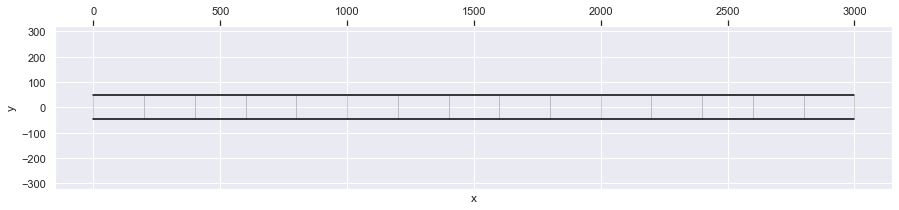

61.7354126570155 None
123.47082531403103 None
146.8323839587038 None


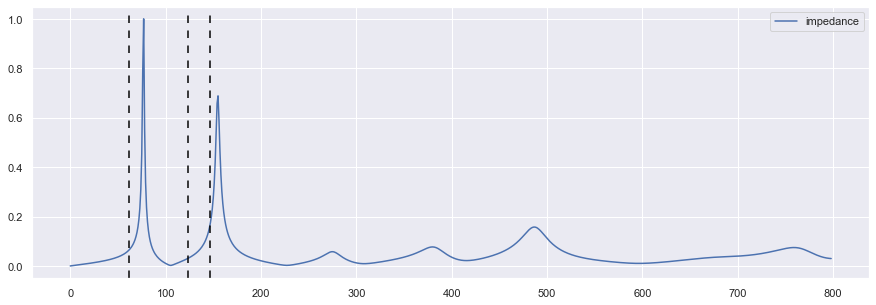

In [85]:

def loss_overblow_freqs(peak, target):
    loss=0
    for i in range(len(target)):
        loss += abs(target[i] - peak.impedance_peaks[i]["freq"])
    return loss   


def mutate(geo, operation):    

    if operation=="change_length":
        factor=0.95+(random.random()/10)
        geo.stretch(factor)
        
    elif operation=="change_segment_diameter":
        factor=0.75+(random.random()/50)
        segment=random.randint(0, len(geo.geo)-1)
        
        if segment==0:
            return mutate(geo, operation)
        geo.geo[segment][1]*=factor
        
    elif operation=="change_segment_position":
        factor=0.75+(random.random()/50)
        segment=random.randint(0, len(geo.geo)-1)
        geo.geo[segment][0]*=factor
        
    else:
        raise Exception("unknown operation " + str(operatino))
        
    return geo

class DidgeVisualizer:
    
    @classmethod
    def create_didge_shape(cls, geo):
        max_y=max([x[1] for x in geo.geo])

        df={"x":[], "y": [], "series": []}
        for i in range(0, len(geo.geo)):
            p=geo.geo[i]

            p_oben=p[1] + d1/2
            p_unten=-1*p[1] - d1/2

            df["x"].append(p[0])
            df["y"].append(p_oben)
            df["series"].append("oben")
            df["x"].append(p[0])
            df["y"].append(p_unten)
            df["series"].append("unten")
            df["x"].append(p[0])
            df["y"].append(p_unten)
            df["series"].append("seg" + str(i))
            df["x"].append(p[0])
            df["y"].append(p_oben)
            df["series"].append("seg" + str(i))

        return pd.DataFrame(df)
    
    @classmethod
    def vis_didge(cls, geo):
        df=Visualizer.create_didge_shape(geo)
        n_series=len(df["series"].unique())
        palette = ["#000000"]*n_series
        sns.set(rc={'figure.figsize':(15,3)})
        g = sns.lineplot(data=df, x="x", y="y", hue="series", palette=palette)
        #g.set(ylim=(0, y_dim))
        #g.set(xlim=(0, x_dim))
        g.get_legend().remove()
        #g.set_yticks([])
        g.xaxis.set_ticks_position("top")
        #g.show()
        plt.axis('equal')
        plt.show()
        
class FFTVisualiser:
    
    @classmethod
    def vis_fft_and_target(cls, fft, target):
        
        fft=fft.copy()
        
        fft=fft.drop(columns=["ground", "overblow", "freq"])
        for column in fft.columns:
            fft[column]=fft[column] / fft[column].max()
        sns.set(rc={'figure.figsize':(15,5)})
        sns.lineplot(data=fft)
        
        for t in target:
            note_number=Note.freq_to_note(t)
            print(t, note_number)
            plt.axvline(t, 0, 1, color="black", dashes=[5,5])
        plt.show()


def evolve(geo, target):
    
    generation_size=10
    n_generations=100
    mutation_operations=["change_length", "change_segment_diameter", "change_segment_position"]
    
    peak, fft=didgmo_bridge(geo)
    father_loss=loss_overblow_freqs(peak, target)
    
    best_loss=father_loss
    best_geo=geo
    
    DidgeVisualizer.vis_didge(geo)
    FFTVisualiser.vis_fft_and_target(fft, target)
    return
    
    with tqdm(total=n_generations*generation_size, bar_format='{l_bar}{bar:30}{r_bar}{bar:-10b}') as pbar:

        for i_gen in range(n_generations):

            loss_before_mutate=best_loss
            for i_mutant in range(generation_size):
                mutation_operation=mutation_operations[random.randint(0, len(mutation_operations)-1)]
                mutant=geo.copy()
                mutant=mutate(mutant, mutation_operation)
                peak=didgmo_bridge(mutant, skip_fft=True)
                
                #peak.print_impedance_peaks()

                
                mutant_loss=loss_overblow_freqs(peak, target)
                if mutant_loss<best_loss:
                    best_geo=mutant
                    best_loss=mutant_loss

                p=i_gen*generation_size + i_mutant
                pbar.update(1)
                pbar.set_description(f"generation={i_gen}, loss={best_loss:.2f}, loss_diff={loss_before_mutate-best_loss}")
            loss_diff=loss_before_mutate-best_loss        
    return best_geo
            
shape=[]
for i in range(16):
    shape.append([i*200, 32])
geo=Geo(geo=shape)

target_notes=[-34, -22, -19]
target_freqs=[note_to_freq(n) for n in target_notes]

best_geo=evolve(geo, target_freqs)

In [31]:

print(geo.geo)
peak=didgmo_bridge(geo, skip_fft=True)
peak.print_impedance_peaks()

mutant=geo.copy()
mutant=mutate(mutant, "change_segment_position")

print(mutant.geo)
peak=didgmo_bridge(mutant, skip_fft=True)
peak.print_impedance_peaks()


[[0, 32], [200, 32], [400, 32], [600, 32], [800, 32], [1000, 32], [1200, 32], [1400, 32], [1600, 32], [1800, 32], [2000, 32], [2200, 32], [2400, 32], [2600, 32], [2800, 32], [3000, 32]]
{A1|028|31}, {F2|085|-47}, {C#3|142|42}, {G3|199|26}, {C4|256|-38}, {D#4|313|10}, {F#4|370|00}, {G#4|427|48}, {H5|484|-35}, {C#5|541|-43}, {D5|598|31}, {E5|655|-12}, {F5|712|33}, {G5|769|-34}, {G#5|826|-10}, {A6|883|05}, {A#6|941|16}, {H6|998|17}
[[0, 32], [200, 32], [400, 32], [600, 32], [800, 32], [1000, 32], [1200, 32], [1400, 32], [1600, 32], [1800, 32], [2000, 32], [2200, 32], [2400, 32], [2652.6029538756347, 32], [2800, 32], [3000, 32]]
{A1|028|31}, {F2|085|-47}, {C#3|142|42}, {G3|199|26}, {C4|256|-38}, {D#4|313|10}, {F#4|370|00}, {G#4|427|48}, {H5|484|-35}, {C#5|541|-43}, {D5|598|31}, {E5|655|-12}, {F5|712|33}, {G5|769|-34}, {G#5|826|-10}, {A6|883|05}, {A#6|941|16}, {H6|998|17}


In [16]:
from time import sleep
with tqdm(total=100) as pbar:
    for i in range(10):
        sleep(0.1)
        pbar.update(10)


100%|██████████| 100/100 [00:01<00:00, 98.00it/s]


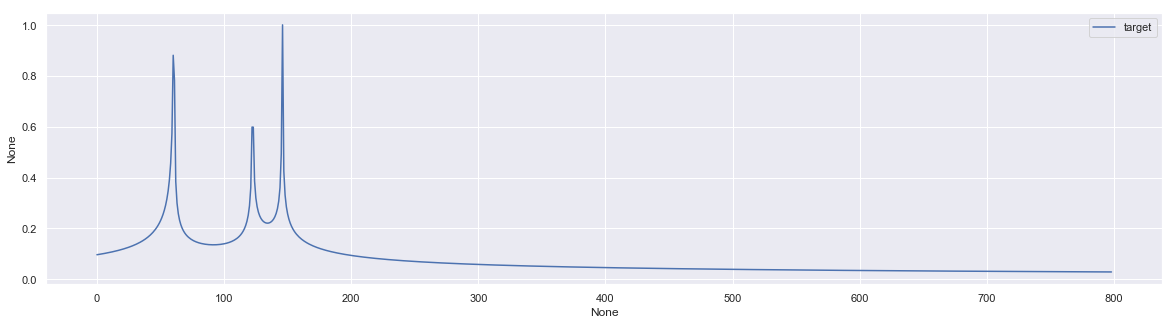

In [231]:


def draw_fft(fft):
    fft=fft.copy()
    fft=fft.drop(columns="freq")
    for column in fft.columns:
        fft[column]=fft[column] / fft[column].max()
    sns.set(rc={'figure.figsize':(20,5)})
    sns.lineplot(data=fft)

def generate_target(target_notes, limit):
    target_freqs=[note_to_freq(n) for n in target_notes]
    peak_size=30
    df={
        "freq": [],
        "target": []
    }
    for freq in range(1, limit):
        
        # generate overtones
        for index in range(len(target_freqs)):
            
            if target_freqs[index] >= freq:
                break
                
        neighbours=None
        if index==0:
            neighbours=[target_freqs[0]]
        elif index==len(target_freqs):
            neighbours=[target_freqs[-1]]
        else:
            neighbours=[target_freqs[index-1], target_freqs[index]]
    
        target=0
        for t in neighbours:
            target+=1/abs(pow(t-freq, 0.5))
        target/=len(neighbours)
        
        # descend overtones
        end=0
        freq=
        
        
        #target=1/target
        df["freq"].append(freq)
        df["target"].append(target)
    df= pd.DataFrame(df)
    df["target"]=df["target"]/df["target"].max()
    return df    

target_notes=[-34, -22, -19]
df=generate_target(target_notes, 800)

fft=pd.read_csv("sample.fft", delimiter=" ", names=["freq", "impedance", "ground", "overblow"])
#fft["target"]=df["target"]
fft["target"]=df["target"]
draw_fft(df)

In [188]:
def loss_overblow_only(geo, target):
    

1.0


{E1|042|33}, {G#2|101|-48}, {D#3|153|-29}, {G#3|207|-06}, {C#4|273|-27}
[[0, 32], [700.0, 32], [800.0, 66.66666666666666], [900.0, 32], [1000.0, 32], [1100.0, 83.33333333333333], [1200.0, 32], [1300.0, 32], [1400.0, 100.0], [1500.0, 32], [1600.0, 32], [1700.0, 116.66666666666666], [1800.0, 32], [1900.0, 32], [2000.0, 133.33333333333334]]


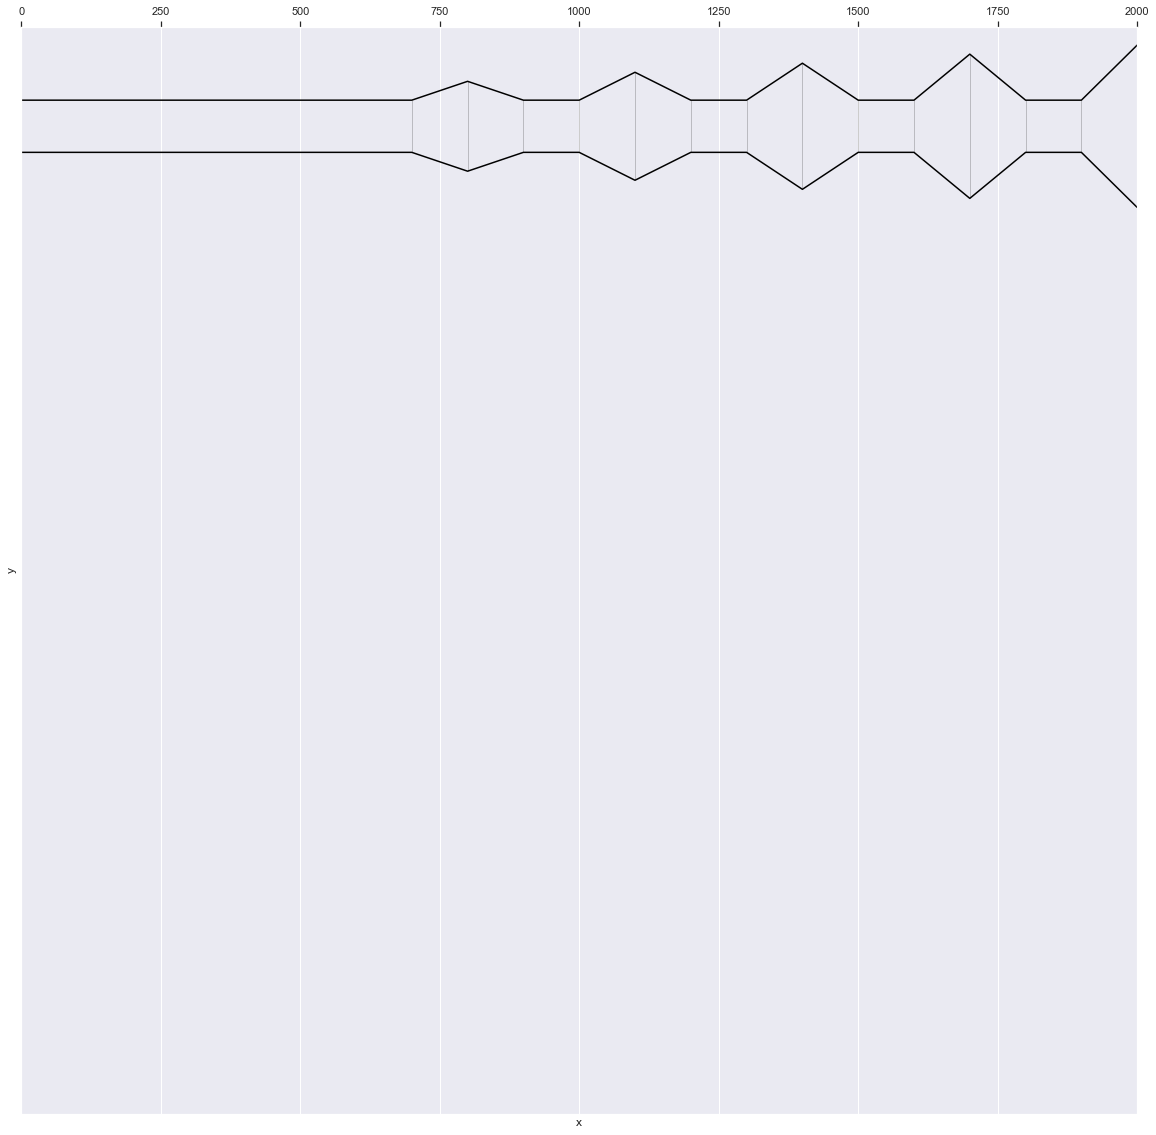

In [41]:

def draw_shape(geo, peaks, n_fundamentals):
    
    margin_top=50
    x_dim=math.ceil(geo.geo[-1][0])
    y_dim=x_dim
    
    max_y=max([x[1] for x in geo.geo])
    didge_shift=y_dim-max_y-margin_top
    d1=32

    df={"x":[], "y": [], "series": []}
    for i in range(0, len(geo.geo)):
        p=geo.geo[i]

        p_oben=p[1] + didge_shift + d1/2
        p_unten=-1*p[1] + didge_shift - d1/2
        
        df["x"].append(p[0])
        df["y"].append(p_oben)
        df["series"].append("oben")
        df["x"].append(p[0])
        df["y"].append(p_unten)
        df["series"].append("unten")
        df["x"].append(p[0])
        df["y"].append(p_unten)
        df["series"].append("seg" + str(i))
        df["x"].append(p[0])
        df["y"].append(p_oben)
        df["series"].append("seg" + str(i))
        
    n_resolution=10
    amp=100
    max_didge=margin_top+geo.geo[-1][1]
    fundamental_margin=100
    for i in range(n_fundamentals):
        zero=y_dim - max_didge - amp*2*(i+1) - fundamental_margin*i
        freq=peaks.impedance_peaks[i]["freq"]
        wavelength=1000*343/freq
        series="fundamental" + str(i)
        for j in range(x_dim):
            x=j*n_resolution
            y1=math.sin(x*2*math.pi/wavelength + math.pi/2)*amp
            y2=-1*y1
            y1+=zero
            y2+=zero
            df["x"].append(x)
            df["y"].append(y1) 
            df["series"].append(series + "o")
            df["x"].append(x)
            df["y"].append(y2)
            df["series"].append(series + "u")
        
        df["x"].append(0)
        df["x"].append(x_dim)
        df["y"].append(zero)
        df["y"].append(zero)
        df["series"].append("base" + str(i))
        df["series"].append("base" + str(i))
        
    df=pd.DataFrame(df)
    n_series=len(df["series"].unique())
    palette = ["#000000"]*n_series
    sns.set(rc={'figure.figsize':(20,20)})
    g = sns.lineplot(data=df, x="x", y="y", hue="series", palette=palette)
    g.set(ylim=(0, y_dim))
    g.set(xlim=(0, x_dim))
    g.get_legend().remove()
    g.set_yticks([])
    g.xaxis.set_ticks_position("top")

'''
d1=32
d2=90
length=1000
n_segments=10

geo=Geo.make_cone(length, d1, d2, n_segments)
new_shape=[[0, d1]]
for i in range(len(geo.geo)):
    new_shape.append(
        [geo.geo[i][0]+1000, geo.geo[i][1]]
    )
'''
'''new_shape=[[0,16],
[800,16],
[900,19],
[970,21],
[1050,20],
[1172,24],
[1350,30],
[1390,34],
[1500,36]]
for i in range(len(new_shape)):
    new_shape[i][1]=2*new_shape[i][1]
'''


'''
shape=[
    [0,32],
    [700, 32],
    [800, 50],
    [900, 40],
    [1100, 50],
    [1250, 60],
    [1500, 70]
]
'''

d1=32
shape=[
    [0,d1]
]
length=2000

n_segments=5
shift=100
for i in range(1, n_segments+1):
    pos=500+i*(length-500)/n_segments
    d2=50*(1+i/3)
    shape.append([pos-shift, d1])
    shape.append([pos, d2])
    
    if i<n_segments:
        shape.append([pos+shift, d1])
    
geo=Geo(geo=shape)
peaks, _=didgmo_bridge(geo)
peaks.print_impedance_peaks(limit=5)
print(geo.geo)
draw_shape(geo, peaks, 0)
